In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cpu


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Dataset must be from DGL
dataset_name = 'WisconsinDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: WisconsinDataset
Number of nodes: 251
Number of features: 1703
Shape of signals: torch.Size([251, 1703])
Number of classes: 5
Norm of A: 22.69361114501953
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.13
Edge homophily: 0.20


# Without normalizing the GSO

In [4]:
# BEST PARAMETERS  - 0.61
## Reaining params
N_RUNS = 20
N_EPOCHS = 500  # 500
LR = .005  # .01
WD = .01  # .005
DROPOUT = .25

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 2  # 2
HID_DIM = 32 # 8

## Model params
h0 = 1  # 1
NORM = False

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ReLU()
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [5]:
# Parameters
epochs = N_EPOCHS
lr = LR
wd = WD
drop = DROPOUT
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
norm = False
act = ACT
lact = LAST_ACT
loss = LOSS_FN
patience = 300

iters_aux = 1

err1 = np.zeros(iters_aux)
err2 = np.zeros(iters_aux)
for i in range(iters_aux):
    # Create model
    arch = GFGCN(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
                dropout=drop, diff_layer=GFGCN_noh_Layer)

    S = torch.Tensor(A).to(device)
    model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
    loss, acc = model.train(feat, labels, epochs, lr, wd, patience=patience)

    idx_max_acc = np.argmax(acc["val"])
    print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}  -  Best test acc: {np.max(acc["test"]):.3f}')
    acc_val = model.test(feat, model.S, labels, masks['val'])
    acc_test = model.test(feat, model.S, labels, masks['test'])
    print(f'Test acc (based on loss): {acc_test:.3f}')

    err1[i] = acc["test"][idx_max_acc]
    err2[i] = acc_test

Test acc at best val: 0.745  -  Best test acc: 0.784
Test acc (based on loss): 0.725


Acc at best val acc: 0.745 +- 0.000
Acc at test: 0.725 +- 0.000


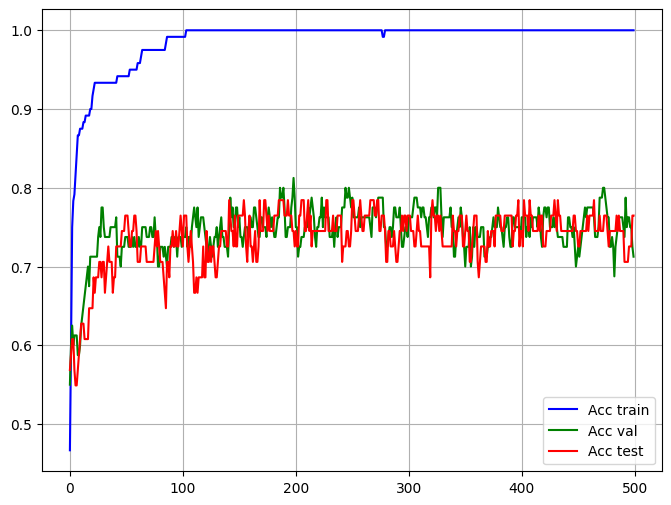

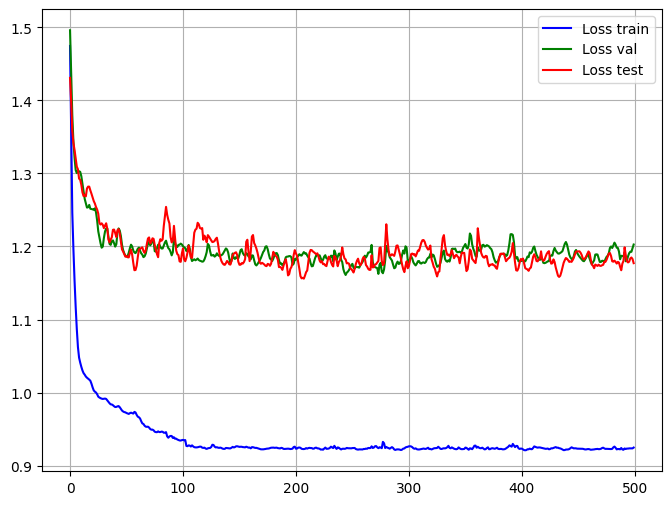

In [6]:
print(f'Acc at best val acc: {err1.mean():.3f} +- {err1.std():.3f}')
print(f'Acc at test: {err2.mean():.3f} +- {err1.std():.3f}')

# Plot
plt.figure(figsize=[8,6])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[8,6])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [7]:
EXPS = [
        {'epochs': 500, 'lr': .05, 'wd': 5e-4, 'drop': .25},
        {'epochs': 500, 'lr': .01, 'wd': 5e-4, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 5e-4, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 5e-4, 'drop': .25},
        
        {'epochs': 500, 'lr': .05, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 500, 'lr': .05, 'wd': 5e-3, 'drop': .25},
        {'epochs': 500, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 5e-3, 'drop': .25},

        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .01, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 1e-2, 'drop': .25},

        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': 0},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': 0},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .5},

        {'epochs': 100, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 1000, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)



-1: 500-0.05-0.0005-0.25: 0.706 (0.804)
-1: 500-0.01-0.0005-0.25: 0.667 (0.725)
-1: 500-0.005-0.0005-0.25: 0.667 (0.765)
-1: 500-0.001-0.0005-0.25: 0.686 (0.725)
-1: 500-0.05-0.001-0.25: 0.706 (0.784)
-1: 500-0.01-0.001-0.25: 0.706 (0.784)
-1: 500-0.005-0.001-0.25: 0.706 (0.745)
-1: 500-0.001-0.001-0.25: 0.725 (0.745)
-1: 500-0.05-0.005-0.25: 0.686 (0.765)
-1: 500-0.01-0.005-0.25: 0.725 (0.784)
-1: 500-0.005-0.005-0.25: 0.765 (0.784)
-1: 500-0.001-0.005-0.25: 0.784 (0.784)
-1: 500-0.05-0.01-0.25: 0.725 (0.804)
-1: 500-0.01-0.01-0.25: 0.745 (0.784)
-1: 500-0.005-0.01-0.25: 0.765 (0.784)
-1: 500-0.001-0.01-0.25: 0.765 (0.784)
-1: 500-0.005-0.001-0: 0.627 (0.706)
-1: 500-0.005-0.001-0.5: 0.706 (0.745)
-1: 500-0.001-0.001-0: 0.765 (0.765)
-1: 500-0.001-0.001-0.5: 0.725 (0.725)
-1: 100-0.005-0.001-0.25: 0.784 (0.784)
-1: 200-0.005-0.001-0.25: 0.706 (0.784)
-1: 1000-0.005-0.001-0.25: 0.706 (0.784)
-2: 500-0.05-0.0005-0.25: 0.824 (0.863)
-2: 500-0.01-0.0005-0.25: 0.843 (0.882)
-2: 500-0.005-0

In [8]:
table1


,mean accs,med,std
500-0.05-0.0005-0.25,0.702941,0.715686,0.078743
500-0.01-0.0005-0.25,0.747059,0.735294,0.066175
500-0.005-0.0005-0.25,0.756863,0.754902,0.052394
500-0.001-0.0005-0.25,0.739216,0.735294,0.047263
500-0.05-0.001-0.25,0.723529,0.705882,0.051840
500-0.01-0.001-0.25,0.764706,0.774510,0.040660
500-0.005-0.001-0.25,0.767647,0.774510,0.042633
500-0.001-0.001-0.25,0.748039,0.735294,0.049323
500-0.05-0.005-0.25,0.730392,0.725490,0.056787
500-0.01-0.005-0.25,0.770588,0.774510,0.046442


In [9]:
table_over1

,mean accs,med,std
500-0.05-0.0005-0.25,0.761765,0.764706,0.064221
500-0.01-0.0005-0.25,0.812745,0.803922,0.047008
500-0.005-0.0005-0.25,0.804902,0.794118,0.044917
500-0.001-0.0005-0.25,0.773529,0.774510,0.039448
500-0.05-0.001-0.25,0.782353,0.784314,0.050335
500-0.01-0.001-0.25,0.823529,0.823529,0.038223
500-0.005-0.001-0.25,0.819608,0.823529,0.038021
500-0.001-0.001-0.25,0.782353,0.784314,0.051468
500-0.05-0.005-0.25,0.798039,0.784314,0.043888
500-0.01-0.005-0.25,0.825490,0.823529,0.041083


## Architecture design - Bias True

In [10]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 4, 'hid_dim': 8},

        {'L': 3, 'K': 2, 'hid_dim': 8},
        {'L': 4, 'K': 2, 'hid_dim': 8},
        {'L': 3, 'K': 3, 'hid_dim': 8},
        {'L': 4, 'K': 3, 'hid_dim': 8},

        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},
    
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 32},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 4, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        {'L': 4, 'K': 3, 'hid_dim': 32},

        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 3, 'hid_dim': 64},
        {'L': 2, 'K': 4, 'hid_dim': 64},

        {'L': 3, 'K': 2, 'hid_dim': 64},
        {'L': 4, 'K': 2, 'hid_dim': 64},
        {'L': 3, 'K': 3, 'hid_dim': 64},
        {'L': 4, 'K': 3, 'hid_dim': 64},

        {'L': 2, 'K': 2, 'hid_dim': 100},
        {'L': 2, 'K': 3, 'hid_dim': 100},
        {'L': 2, 'K': 4, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 100},
        {'L': 4, 'K': 2, 'hid_dim': 100},
        {'L': 3, 'K': 3, 'hid_dim': 100},
        {'L': 4, 'K': 3, 'hid_dim': 100},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-8: 0.765 (0.824)
-1: 2-3-8: 0.686 (0.725)
-1: 2-4-8: 0.569 (0.647)
-1: 3-2-8: 0.706 (0.824)
-1: 4-2-8: 0.706 (0.765)
-1: 3-3-8: 0.706 (0.725)
-1: 4-3-8: 0.529 (0.627)
-1: 2-2-16: 0.745 (0.784)
-1: 2-3-16: 0.686 (0.745)
-1: 2-4-16: 0.608 (0.725)
-1: 3-2-16: 0.647 (0.765)
-1: 4-2-16: 0.686 (0.765)
-1: 3-3-16: 0.627 (0.765)
-1: 4-3-16: 0.569 (0.608)
-1: 2-2-32: 0.745 (0.765)
-1: 2-3-32: 0.686 (0.725)
-1: 2-4-32: 0.647 (0.706)
-1: 3-2-32: 0.745 (0.784)
-1: 4-2-32: 0.804 (0.824)
-1: 3-3-32: 0.667 (0.725)
-1: 4-3-32: 0.588 (0.667)
-1: 2-2-64: 0.745 (0.784)
-1: 2-3-64: 0.588 (0.706)
-1: 2-4-64: 0.569 (0.706)
-1: 3-2-64: 0.765 (0.824)
-1: 4-2-64: 0.686 (0.784)
-1: 3-3-64: 0.627 (0.725)
-1: 4-3-64: 0.588 (0.667)
-1: 2-2-100: 0.765 (0.804)
-1: 2-3-100: 0.647 (0.745)
-1: 2-4-100: 0.627 (0.706)
-1: 3-2-100: 0.706 (0.784)
-1: 4-2-100: 0.725 (0.784)
-1: 3-3-100: 0.706 (0.725)
-1: 4-3-100: 0.451 (0.647)
-2: 2-2-8: 0.882 (0.902)
-2: 2-3-8: 0.804 (0.843)
-2: 2-4-8: 0.686 (0.824)
-2: 3-2-8: 0.76

In [11]:
table3

,mean accs,med,std
2-2-8,0.770588,0.764706,0.056863
2-3-8,0.713725,0.725490,0.055251
2-4-8,0.652941,0.666667,0.056524
3-2-8,0.736275,0.745098,0.052053
4-2-8,0.690196,0.686275,0.081932
3-3-8,0.688235,0.676471,0.071212
4-3-8,0.593137,0.598039,0.074374
2-2-16,0.779412,0.784314,0.049942
2-3-16,0.715686,0.705882,0.043625
2-4-16,0.637255,0.627451,0.066926


In [12]:
table_over3

,mean accs,med,std
2-2-8,0.811765,0.803922,0.049759
2-3-8,0.765686,0.784314,0.046183
2-4-8,0.709804,0.705882,0.047869
3-2-8,0.798039,0.803922,0.049643
4-2-8,0.751961,0.745098,0.062707
3-3-8,0.722549,0.725490,0.059239
4-3-8,0.650000,0.666667,0.072383
2-2-16,0.823529,0.823529,0.038223
2-3-16,0.769608,0.764706,0.039642
2-4-16,0.708824,0.725490,0.060840


## Architecture design - Bias False

In [13]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 4},
        {'L': 2, 'K': 3, 'hid_dim': 4},
        {'L': 2, 'K': 4, 'hid_dim': 4},

        {'L': 3, 'K': 2, 'hid_dim': 4},
        {'L': 4, 'K': 2, 'hid_dim': 4},
        {'L': 3, 'K': 3, 'hid_dim': 4},
        {'L': 4, 'K': 3, 'hid_dim': 4},

        {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 4, 'hid_dim': 8},

        {'L': 3, 'K': 2, 'hid_dim': 8},
        {'L': 4, 'K': 2, 'hid_dim': 8},
        {'L': 3, 'K': 3, 'hid_dim': 8},
        {'L': 4, 'K': 3, 'hid_dim': 8},
    
        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 32},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 4, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        {'L': 4, 'K': 3, 'hid_dim': 32},

        {'L': 2, 'K': 2, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 4, 'hid_dim': 50},

        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 4, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        {'L': 4, 'K': 3, 'hid_dim': 50},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3b = summary_table(best_accs3b, index_name)
table3b = summary_table(best_val_accs3b, index_name)

-1: 2-2-4: 0.765 (0.824)
-1: 2-3-4: 0.686 (0.725)
-1: 2-4-4: 0.569 (0.647)
-1: 3-2-4: 0.706 (0.824)
-1: 4-2-4: 0.706 (0.765)
-1: 3-3-4: 0.706 (0.725)
-1: 4-3-4: 0.529 (0.627)
-1: 2-2-8: 0.745 (0.784)
-1: 2-3-8: 0.686 (0.745)
-1: 2-4-8: 0.608 (0.725)
-1: 3-2-8: 0.647 (0.765)
-1: 4-2-8: 0.686 (0.765)
-1: 3-3-8: 0.627 (0.765)
-1: 4-3-8: 0.569 (0.608)
-1: 2-2-16: 0.745 (0.765)
-1: 2-3-16: 0.686 (0.725)
-1: 2-4-16: 0.647 (0.706)
-1: 3-2-16: 0.745 (0.784)
-1: 4-2-16: 0.804 (0.824)
-1: 3-3-16: 0.667 (0.725)
-1: 4-3-16: 0.588 (0.667)
-1: 2-2-32: 0.745 (0.784)
-1: 2-3-32: 0.588 (0.706)
-1: 2-4-32: 0.569 (0.706)
-1: 3-2-32: 0.765 (0.824)
-1: 4-2-32: 0.686 (0.784)
-1: 3-3-32: 0.627 (0.725)
-1: 4-3-32: 0.588 (0.667)
-1: 2-2-50: 0.765 (0.804)
-1: 2-3-50: 0.647 (0.745)
-1: 2-4-50: 0.627 (0.706)
-1: 3-2-50: 0.706 (0.784)
-1: 4-2-50: 0.725 (0.784)
-1: 3-3-50: 0.706 (0.725)
-1: 4-3-50: 0.451 (0.647)
-2: 2-2-4: 0.882 (0.902)
-2: 2-3-4: 0.804 (0.843)
-2: 2-4-4: 0.686 (0.824)
-2: 3-2-4: 0.765 (0.843)
-2: 

In [14]:
table3b

,mean accs,med,std
2-2-4,0.733333,0.735294,0.043581
2-3-4,0.687255,0.686275,0.074787
2-4-4,0.627451,0.588235,0.074664
3-2-4,0.678431,0.676471,0.064557
4-2-4,0.683333,0.686275,0.054507
3-3-4,0.642157,0.637255,0.061967
4-3-4,0.600980,0.598039,0.093888
2-2-8,0.769608,0.774510,0.043348
2-3-8,0.709804,0.705882,0.053555
2-4-8,0.615686,0.617647,0.063658


In [15]:
# table_over3b

## Nonlinearities and loss function

In [16]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.725 (0.804)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.765 (0.804)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.647 (0.784)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.706 (0.784)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.765 (0.784)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.784 (0.804)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.765 (0.784)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.745 (0.824)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.745 (0.784)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.765 (0.804)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.765 (0.784)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.882 (0.902)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.863 (0.902)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.882 (0.902)
-2: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.863 (0.882)
-2: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.902)
-2: ELU(alp

In [17]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.775490,0.774510,0.051309
ReLU()-Softmax(dim=1)-NLLLoss(),0.780392,0.784314,0.045817
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.765686,0.774510,0.067775
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.772549,0.764706,0.045733
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.769608,0.764706,0.040601
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.775490,0.764706,0.048616
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.770588,0.764706,0.048862
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.789216,0.784314,0.038160
Identity()-Softmax(dim=1)-CrossEntropyLoss(),0.782353,0.784314,0.045098
Identity()-Softmax(dim=1)-NLLLoss(),0.780392,0.784314,0.047059


In [18]:
table_over4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.833333,0.813725,0.041363
ReLU()-Softmax(dim=1)-NLLLoss(),0.826471,0.823529,0.037345
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.821569,0.833333,0.047587
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.822549,0.803922,0.041813
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.825490,0.813725,0.046772
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.835294,0.843137,0.039411
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.828431,0.833333,0.041537
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.823529,0.823529,0.033962
Identity()-Softmax(dim=1)-CrossEntropyLoss(),0.830392,0.823529,0.048537
Identity()-Softmax(dim=1)-NLLLoss(),0.829412,0.833333,0.045183


# Normalizing the GSO

In [19]:
N_RUNS = 3
NORM = True

## Training paramerters

In [20]:
EXPS = [
        {'epochs': 200, 'lr': .5, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': 0},
        
        # {'epochs': 200, 'lr': .05, 'wd': 1e-3, 'drop': 0},
        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        # {'epochs': 200, 'lr': .05, 'wd': 5e-2, 'drop': 0},

        # {'epochs': 200, 'lr': .1, 'wd': 1e-3, 'drop': 0},
        # {'epochs': 200, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        # {'epochs': 200, 'lr': .1, 'wd': 5e-2, 'drop': 0},
        
        # {'epochs': 500, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        # {'epochs': 500, 'lr': .01, 'wd': 1e-2, 'drop': 0},

        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 750, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 750, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        ]

best_accs5 = np.zeros((len(EXPS), N_RUNS))
best_val_accs5 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs5[j,i] = np.max(acc["test"])
        best_val_accs5[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs5[j,i]:.3f} ({best_accs5[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over5 = summary_table(best_accs5, index_name)
table5 = summary_table(best_val_accs5, index_name)



/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 200-0.5-0.0005-0: 0.020 (0.020)
-1: 200-0.1-0.0005-0: 0.020 (0.020)
-2: 200-0.5-0.0005-0: 0.039 (0.039)
-2: 200-0.1-0.0005-0: 0.039 (0.039)
-3: 200-0.5-0.0005-0: 0.039 (0.039)
-3: 200-0.1-0.0005-0: 0.039 (0.039)
----- 0.07 mins -----


In [21]:
table5

,mean accs,med,std
200-0.5-0.0005-0,0.03268,0.039216,0.009243
200-0.1-0.0005-0,0.03268,0.039216,0.009243


## Architecture design

In [22]:
# layers, filter order, weightd
EXPS = [
    # {'L': 2, 'K': 2, 'hid_dim': 4},
        # {'L': 2, 'K': 3, 'hid_dim': 4},
        # {'L': 2, 'K': 4, 'hid_dim': 4},

        # {'L': 3, 'K': 2, 'hid_dim': 4},
        # {'L': 4, 'K': 2, 'hid_dim': 4},
        # {'L': 3, 'K': 3, 'hid_dim': 4},
        # {'L': 4, 'K': 3, 'hid_dim': 4},

        # {'L': 2, 'K': 2, 'hid_dim': 8},
        # {'L': 2, 'K': 3, 'hid_dim': 8},
        # {'L': 2, 'K': 4, 'hid_dim': 8},

        # {'L': 3, 'K': 2, 'hid_dim': 8},
        # {'L': 4, 'K': 2, 'hid_dim': 8},
        # {'L': 3, 'K': 3, 'hid_dim': 8},
        # {'L': 4, 'K': 3, 'hid_dim': 8},
    
        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        # {'L': 2, 'K': 2, 'hid_dim': 32},
        # {'L': 2, 'K': 3, 'hid_dim': 32},
        # {'L': 2, 'K': 4, 'hid_dim': 32},

        # {'L': 3, 'K': 2, 'hid_dim': 32},
        # {'L': 4, 'K': 2, 'hid_dim': 32},
        # {'L': 3, 'K': 3, 'hid_dim': 32},
        # {'L': 4, 'K': 3, 'hid_dim': 32},
        ]

best_accs7 = np.zeros((len(EXPS), N_RUNS))
best_val_accs7 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs7[j,i] = np.max(acc["test"])
        best_val_accs7[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs7[j,i]:.3f} ({best_accs7[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over7 = summary_table(best_accs7, index_name)
table7 = summary_table(best_val_accs7, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 2-2-16: 0.020 (0.020)
-1: 2-3-16: 0.020 (0.020)
-1: 2-4-16: 0.020 (0.020)
-1: 3-2-16: 0.020 (0.020)
-1: 4-2-16: 0.020 (0.020)
-1: 3-3-16: 0.020 (0.020)
-1: 4-3-16: 0.020 (0.020)
-2: 2-2-16: 0.039 (0.039)
-2: 2-3-16: 0.039 (0.039)
-2: 2-4-16: 0.039 (0.039)
-2: 3-2-16: 0.039 (0.039)
-2: 4-2-16: 0.039 (0.039)
-2: 3-3-16: 0.039 (0.039)
-2: 4-3-16: 0.039 (0.039)
-3: 2-2-16: 0.039 (0.039)
-3: 2-3-16: 0.039 (0.039)
-3: 2-4-16: 0.039 (0.039)
-3: 3-2-16: 0.039 (0.039)
-3: 4-2-16: 0.039 (0.039)
-3: 3-3-16: 0.039 (0.039)
-3: 4-3-16: 0.039 (0.039)
----- 0.30 mins -----


In [23]:
table7

,mean accs,med,std
2-2-16,0.03268,0.039216,0.009243
2-3-16,0.03268,0.039216,0.009243
2-4-16,0.03268,0.039216,0.009243
3-2-16,0.03268,0.039216,0.009243
4-2-16,0.03268,0.039216,0.009243
3-3-16,0.03268,0.039216,0.009243
4-3-16,0.03268,0.039216,0.009243


## Nonlinearities and loss function

In [24]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        # {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        # {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        # {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs8 = np.zeros((len(EXPS), N_RUNS))
best_val_accs8 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs8[j,i] = np.max(acc["test"])
        best_val_accs8[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs8[j,i]:.3f} ({best_accs8[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over8 = summary_table(best_accs8, index_name)
table8 = summary_table(best_val_accs8, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.020 (0.020)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.020 (0.020)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.039 (0.039)
-2: Identity()-Identity()-CrossEntropyLoss(): 0.039 (0.039)
-3: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.039 (0.039)
-3: Identity()-Identity()-CrossEntropyLoss(): 0.039 (0.039)
----- 0.06 mins -----


In [25]:
table8

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.03268,0.039216,0.009243
Identity()-Identity()-CrossEntropyLoss(),0.03268,0.039216,0.009243


# Comparing Models

In [26]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False}, # This should be the same as A-GCNN not norm
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [27]:
N_RUNS = 20

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)

        loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1


	Kipf-none: acc = 0.549  -  acc (over) = 0.627
	Kipf-both: acc = 0.608  -  acc (over) = 0.627
	A-GCNN-False: acc = 0.824  -  acc (over) = 0.843


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


	A-GCNN-True: acc = 0.020  -  acc (over) = 0.020
	H-GCNN-False: acc = 0.824  -  acc (over) = 0.843
	H-GCNN-True: acc = 0.588  -  acc (over) = 0.608
	W-GCN-A-False: acc = 0.745  -  acc (over) = 0.784
	W-GCN-A-True: acc = 0.020  -  acc (over) = 0.020
- RUN: 2
	Kipf-none: acc = 0.412  -  acc (over) = 0.627
	Kipf-both: acc = 0.686  -  acc (over) = 0.706
	A-GCNN-False: acc = 0.863  -  acc (over) = 0.922
	A-GCNN-True: acc = 0.039  -  acc (over) = 0.039
	H-GCNN-False: acc = 0.882  -  acc (over) = 0.922
	H-GCNN-True: acc = 0.882  -  acc (over) = 0.922
	W-GCN-A-False: acc = 0.843  -  acc (over) = 0.902
	W-GCN-A-True: acc = 0.039  -  acc (over) = 0.039
- RUN: 3
	Kipf-none: acc = 0.588  -  acc (over) = 0.627
	Kipf-both: acc = 0.608  -  acc (over) = 0.627
	A-GCNN-False: acc = 0.863  -  acc (over) = 0.922
	A-GCNN-True: acc = 0.039  -  acc (over) = 0.039
	H-GCNN-False: acc = 0.882  -  acc (over) = 0.902
	H-GCNN-True: acc = 0.843  -  acc (over) = 0.882
	W-GCN-A-False: acc = 0.804  -  acc (over) = 0.8

In [28]:
table_comp

,mean accs,med,std
Kipf-none,0.544118,0.568627,0.080577
Kipf-both,0.590196,0.607843,0.050716
A-GCNN-False,0.803922,0.843137,0.124475
A-GCNN-True,0.037255,0.039216,0.018498
H-GCNN-False,0.832353,0.852941,0.105860
H-GCNN-True,0.776471,0.823529,0.121410
W-GCN-A-False,0.781373,0.784314,0.044831
W-GCN-A-True,0.037255,0.039216,0.018498


In [29]:
table_comp2

,mean accs,med,std
Kipf-none,0.537255,0.549020,0.079502
Kipf-both,0.587255,0.588235,0.055968
A-GCNN-False,0.800980,0.843137,0.124826
A-GCNN-True,0.037255,0.039216,0.018498
H-GCNN-False,0.827451,0.852941,0.104971
H-GCNN-True,0.768627,0.794118,0.125337
W-GCN-A-False,0.760784,0.764706,0.039992
W-GCN-A-True,0.037255,0.039216,0.018498


In [30]:
table_comp_over

,mean accs,med,std
Kipf-none,0.602941,0.627451,0.081290
Kipf-both,0.637255,0.627451,0.043182
A-GCNN-False,0.838235,0.872549,0.116807
A-GCNN-True,0.037255,0.039216,0.018498
H-GCNN-False,0.868627,0.892157,0.074690
H-GCNN-True,0.825490,0.852941,0.098995
W-GCN-A-False,0.828431,0.833333,0.040124
W-GCN-A-True,0.037255,0.039216,0.018498
